 # Video Generator For Multi-Track Audio
  **Goal: visualize the arrangement and mix of my song "10 chlini Rägetropfe"**
  
 (c) 2022 by Andri Krämer / Gschichtefritz
 (p) 2022 Gschichtefritz Records / matlon GmbH
 
 https://www.gschichtefritz.ch
 
  The result / video can be found on YouTube:
https://youtu.be/JGrVT1ECq2E
 
 If you wonder in what weird language this song is sung: it's Swiss German 😀
 

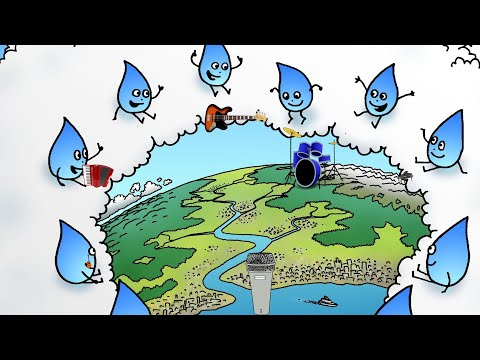

In [13]:
from IPython.display import YouTubeVideo
YouTubeVideo('JGrVT1ECq2E', width=850, height=450)

### Liner Notes
 
 "10 chlini Rägetropfe" originates from my children story "D'Seejungfrau uf Schuelbsuech (De Blaui Dino, nbr. 42)".
  The song was recorded on 2022/05/22 and released 2022/06/15 on gschichtefritz.ch, Spotify, YouTube, Apple Music, ...
 
 - Music and Lyrics: Andri Krämer
 - Vocals & Harmonica: Gschichtefritz (Andri Krämer)
 - Accordion & Piano: Michael Landolf
 - Guitars: Mark Lim
 - Bass: Alex Lim
 - Drums & Percussion: Lukas Landis
 
 Recording, Mix & Production: Andri Krämer.  
 EAN/UPC: 0725844474298
 ISRC: CH9442290501

# And now: let's dive into the code
The video is generated with python, using the librosa and pillow packages.

## Package Import

In [2]:
from pathlib import Path
# librosa is used for audio signal analysis. librosa version used: 0.9.1
import librosa
# PIL / pillow is used for generating the images (video frames). used: pillow version 8.0.0
from PIL import Image
# matplotlib is only used to visualize the RMS data of the different channels in this notebook
import matplotlib.pyplot as plt

## Settings

In [3]:
# output images settings (1920x1080 corresponds to HD video resolution: 1080p / 16:9)
out_width = 1920
out_height = 1080
# frames (images) per second we want to be generated. For a quick peek, set to a small vaule such as 2 or 5
# for the final rendering, use 25 or 50
fps = 25
# file path where the generated images should be stored
video_frames_out_path = "c:/Andri/Video/video_frames"

# input
min_img_size = 5
max_img_size = 250

# background image (should have the correct resolution out_width x out_height)
background_img = Image.open("regentropfen-bg.jpg")

# final mix audiofile path
final_mix_file = "c:/Andri/Video/10ChliniRaegetropfeMD9Mastered_16Bit.wav"

# path where the different instrument / group tracks are located
# in my case, there are 9 tracks called
# They all need to have the same lenght as the final mix
# 10ChliniRaegetropfe_Channel_Accordeon.wav
# 10ChliniRaegetropfe_Channel_GRBass.wav
# 10ChliniRaegetropfe_Channel_GRDrums.wav
# 10ChliniRaegetropfe_Channel_GRVox.wav
# 10ChliniRaegetropfe_Channel_Git Mark 2.wav
# 10ChliniRaegetropfe_Channel_Git Mark.wav
# 10ChliniRaegetropfe_Channel_Git Mark3.wav
# 10ChliniRaegetropfe_Channel_Harmonica.wav
# 10ChliniRaegetropfe_Channel_Piano.wav
audiopath = Path("")
channel_prefix = "10ChliniRaegetropfe_Channel_"

tracks = ["GRDrums", "GRBass", "Accordeon","Piano", "Git Mark", "Git Mark 2", "Git Mark3", "Harmonica","GRVox"]
# images corresponding to the audio tracks (same order, same length as tracks array)
img_files = ["Drums.png","Bass.png","Accordion.png","Piano.png","Git1.png","Git2.png","Git3.png","Harmonica.png", "Microphone.png"]
# x/y coordinates where the images should be placed in the video frames (same order, same length as tracks array)
# in my case, each instrument is placed near a raindrop on the background_img and the position corresponds to the panning of the instrument
# in the final mix. e.g. the piano, which is panned to the right, is also placed on the right side of the picture
img_coordinates = [(1122,330), (818,234), (329,477), (1587,504),(1380,351), (1559,816), (346,837),  (549,321), (979,830)]

# factor by which the RMS values should be scaled/multiplied
# depends on the loudness of your audio channel tracks
audio_factor = 5

## Data preparation
Let's analyze the audio files and determine how the RMS ('loudness') values for the different instrument tracks over time

In [4]:
# load an audio file and return arrays containing RMS and timing information
def calc_rms(f):
    y, sr = librosa.load(f)
    rms = librosa.feature.rms(y=y)
    times = librosa.times_like(rms)
    return times,rms

In [5]:
# prepare a dictonary that contains RMS/Amplitude information as well as the image and its coordinates for each track
data = {track:{"img":Image.open(img_files[i]), 
               "img_coordinates":img_coordinates[i],
               "rms":calc_rms(audiopath/f"{channel_prefix}{track}.wav")} 
        for i, track in enumerate(tracks)}

## Take a look at the data
Let's plot the result of our audio track analysis.
That's the data we will later use to render our video

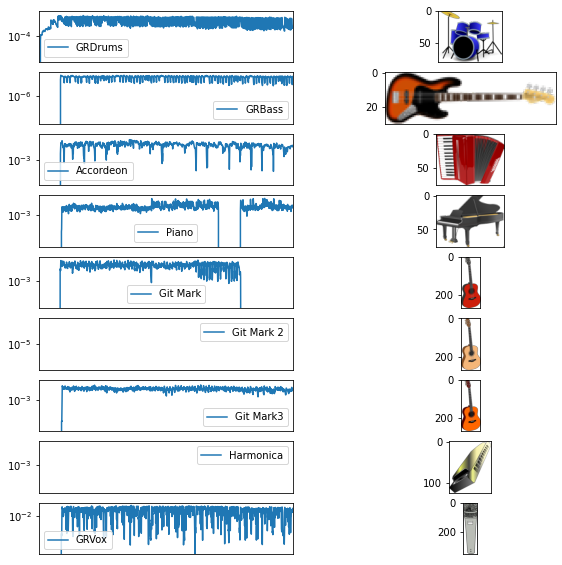

In [6]:
fig, ax = plt.subplots(len(data),2, sharex=True,figsize=(10,10))
i = 0
resize_factor = 0.001
for track_name, track_data in data.items():
    # plot graph
    ax[i,0].semilogy(track_data["rms"][0], track_data["rms"][1][0], label=track_name)
    ax[i,0].set(xticks=[])
    ax[i,0].legend()
    ax[i,0].label_outer()
    # prepate and show thumbnail
    img = track_data["img"].copy()
    img.thumbnail((100,500))
    ax[i,1].imshow(img)
    i+=1

## Determine length and audio/video frames count
Get the length of the audio files, the number of RMS audio_frames and the number of video_frames that will have to bee generated.
Librosa slices the audio into "small frames of the signal which are spaced by a hop length (in samples). The default frame and hop lengths are set to 2048 and 512 samples, respectively. At the default sampling rate of 22050 Hz, this corresponds to overlapping frames of approximately 93ms spaced by 23ms.", quoted from:
https://conference.scipy.org/proceedings/scipy2015/pdfs/brian_mcfee.pdf

In [7]:
# as all tracks must have the same length, we just use the first one (tracks[0]) for reference
audio_frames = len(data[tracks[0]]["rms"][0])
audio_length_seconds = data[tracks[0]]["rms"][0][audio_frames-1]
video_frames = int(fps*audio_length_seconds)

print(f"audio_length_seconds: {audio_length_seconds:.2f}s, audio_frames count: {audio_frames}, video_frames count: {video_frames}")

audio_length_seconds: 231.32s, audio_frames count: 9963, video_frames count: 5782


## Functions to generate output images (video frames)
We need functions to:
1. determine which RMS value (audio frame) is relevant for the given video frame number (`audio_frame_nbr_at()`)
2. get all relevant data to compose an image (`get_at_frame()`)
3. generate a video frame (jpg) where the images representing the different audio tracks are rendered with correct size (according to the RMS value / 'loudness') at the defined position (`compose_img()`)

They are meant to be nested as follows, where data is the preprocessed dictionary from above:
```
compose_img(get_at_frame(data, audio_frame_nbr_at(i)))
```

In [8]:
def audio_frame_nbr_at(video_frame_nbr):
    return int(video_frame_nbr/video_frames*audio_frames)

def get_at_frame(data, i):
    return [{"name":track_name, "img":track_data["img"], 
             "img_coordinates": track_data["img_coordinates"], 
             "rms": track_data["rms"][1][0][i]*audio_factor} 
            for track_name, track_data in data.items()]

def compose_img(data):
    # create new image
    dst = Image.new('RGB', (out_width, out_height))
    # add background image
    dst.paste(background_img)
    # add track/instrument image for each track
    for i, instr in enumerate(data):
        img = instr["img"]
        rms = instr["rms"]
        # bring it to the right size according to the RMS value, respecting min and max sizes
        resized_img = img.resize((int(min(max_img_size, max(min_img_size,rms*img.width))),int(min(max_img_size, max(min_img_size,rms*img.height)))))
        # paste it onto the output image, using the image itself as a mask (I use PNG images with transparency)
        dst.paste(resized_img , instr["img_coordinates"], mask=resized_img)
    return dst

## Example image
Let's see how the video frame nbr. 3000 (which at 25 fps corresponds to the position 2m 0s, because 3000/25=120) would look like:


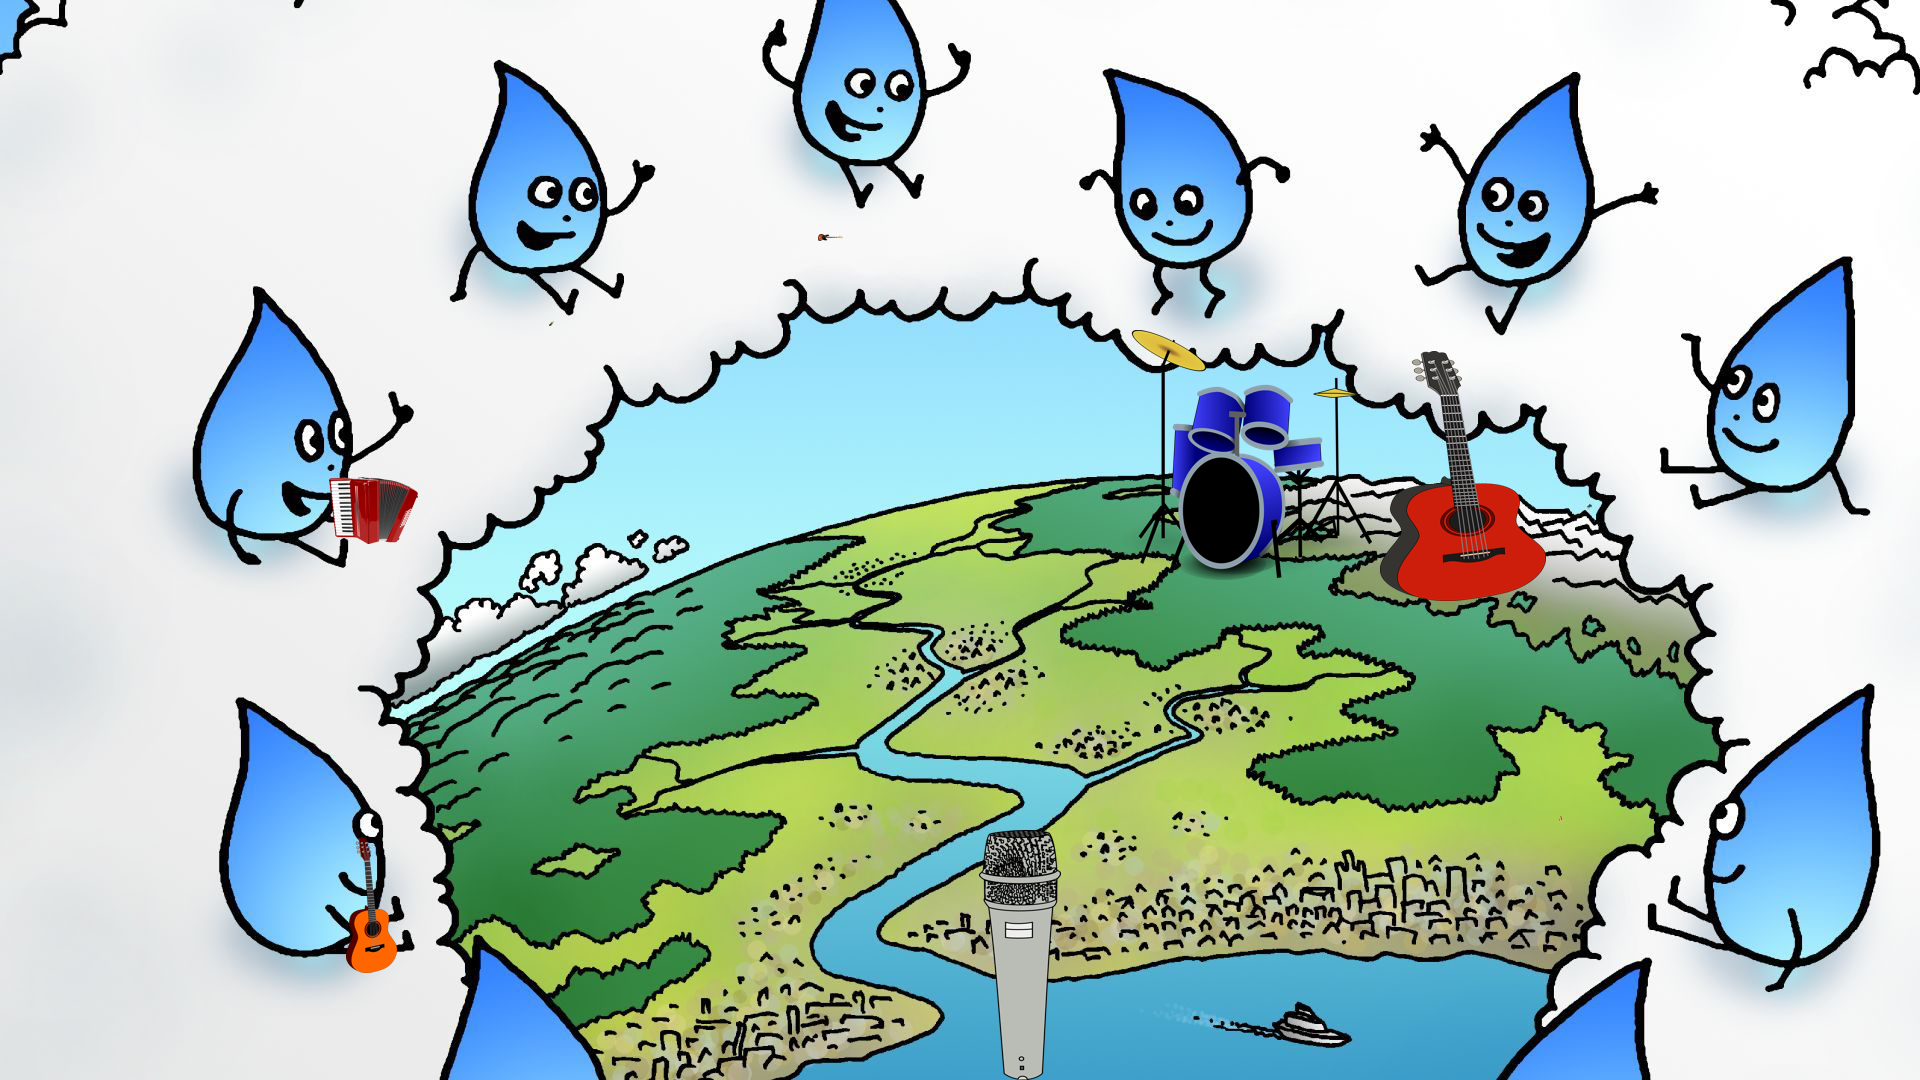

In [9]:
compose_img(get_at_frame(data, audio_frame_nbr_at(120*fps)))

## Generate video frames
Just loop from 0 to `video_frames` and generate and save the image file

In [10]:
for video_frame_nbr in range(video_frames):
    img = compose_img(get_at_frame(data, audio_frame_nbr_at(video_frame_nbr)))
    img.save(f'{video_frames_out_path}/frame_{video_frame_nbr:05d}.jpg')

## Replace intro frames
As a 'teaser', we want to quickly show all the track/instrument images at the beginning of the video, zooming out during the first n (e.g. 2) seconds, thus let's replace the frames of the first n seconds:

In [11]:
def get_intro_at_frame(data, intro_duration, i):
    #show and fade out all images in the first intro_duration seconds
    return [{"name":track_name, "img":track_data["img"], 
             "img_coordinates": track_data["img_coordinates"], 
             "rms": 0.2*(1.0-(i/(fps*intro_duration)))} 
            for track_name, track_data in data.items()]

# add intro (replace images of first 2 seconds)
intro_duration = 2
for video_frame_nbr in range(intro_duration*fps):
    img = compose_img(get_intro_at_frame(data, intro_duration, video_frame_nbr))
    img.save(f'{video_frames_out_path}/frame_{video_frame_nbr:05d}.jpg')

## Usage hints for ffmgpeg
Shows the commands that have to be run after all video frame images have been generated.
The command turns the images into an MP4 video, also adding the final mix audio track to the video

In [12]:
print("Make sure ffmpeg is installed on your machine, then run the following commands in a cmd window:")
# https://trac.ffmpeg.org/wiki/Slideshow
out_fps = fps if fps >= 25 else 25
print(f"cd {video_frames_out_path}")
print(f"ffmpeg -framerate {fps} -i frame_%05d.jpg -i {final_mix_file} -c:v libx264 -r {out_fps} -pix_fmt yuv420p 10ChliniRaegetropfeVideo.mp4")

Make sure ffmpeg is installed on your machine, then run the following commands in a cmd window:
cd c:/Andri/Video/video_frames
ffmpeg -framerate 25 -i frame_%05d.jpg -i c:/Andri/Video/10ChliniRaegetropfeMD9Mastered_16Bit.wav -c:v libx264 -r 25 -pix_fmt yuv420p 10ChliniRaegetropfeVideo.mp4
